# MalMem baseline experiments

Compare several classifiers on Obfuscated-MalMem2022 to decide which to integrate into the Flower client.

Run order:
1) Load data and inspect class balance.
2) Train/test split + standardization.
3) Evaluate multiple models with cross-validation.
4) Select the best trade-off (accuracy/F1 vs. model size/inference cost).

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

DATA_PATH = Path("Obfuscated-MalMem2022.csv")
if not DATA_PATH.exists():
    DATA_PATH = Path("..").joinpath("Obfuscated-MalMem2022.csv")
df = pd.read_csv(DATA_PATH)
print(df.head())
print("Class distribution:\n", df['Class'].value_counts())

# Features/labels
X = df.drop(columns=["Class", "Category"], errors="ignore").values.astype(float)
y = df["Class"].apply(lambda c: 0 if str(c).lower() == "benign" else 1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape", X_train.shape, "Test shape", X_test.shape)
print("Positive ratio (train)", y_train.mean())

  Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0   Benign            45            17           10.555556   
1   Benign            47            19           11.531915   
2   Benign            40            14           14.725000   
3   Benign            32            13           13.500000   
4   Benign            42            16           11.452381   

   pslist.nprocs64bit  pslist.avg_handlers  dlllist.ndlls  \
0                   0           202.844444           1694   
1                   0           242.234043           2074   
2                   0           288.225000           1932   
3                   0           264.281250           1445   
4                   0           281.333333           2067   

   dlllist.avg_dlls_per_proc  handles.nhandles  handles.avg_handles_per_proc  \
0                  38.500000              9129                    212.302326   
1                  44.127660             11385                    242.234043   
2                  4

In [2]:
# Define candidate models - extensive benchmark with SOTA methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Advanced/SOTA models
try:
    from sklearn.experimental import enable_hist_gradient_boosting
except:
    pass

try:
    import optuna.integration.lightgbm as lgb_tuned
except:
    pass

models = {
    # Linear models
    "logreg_l2": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    ),
    "logreg_l1": make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", solver="saga", max_iter=1000, class_weight="balanced", n_jobs=-1),
    ),
    "logreg_elasticnet": make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, max_iter=1000, class_weight="balanced", n_jobs=-1),
    ),
    "linear_svc": make_pipeline(
        StandardScaler(),
        LinearSVC(max_iter=2000, class_weight="balanced", dual="auto"),
    ),
    "svc_rbf": make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", class_weight="balanced", probability=True),
    ),
    "lda": make_pipeline(
        StandardScaler(),
        LinearDiscriminantAnalysis(),
    ),
    "qda": make_pipeline(
        StandardScaler(),
        QuadraticDiscriminantAnalysis(),
    ),
    
    # Tree-based models
    "decision_tree": DecisionTreeClassifier(max_depth=10, class_weight="balanced"),
    "rf_100": RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight="balanced_subsample"),
    "rf_200": RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight="balanced_subsample"),
    "rf_500": RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight="balanced_subsample", max_depth=20),
    "rf_deep": RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight="balanced_subsample", max_depth=None),
    "extra_trees_100": ExtraTreesClassifier(n_estimators=100, n_jobs=-1, class_weight="balanced_subsample"),
    "extra_trees_200": ExtraTreesClassifier(n_estimators=200, n_jobs=-1, class_weight="balanced_subsample"),
    "extra_trees_500": ExtraTreesClassifier(n_estimators=500, n_jobs=-1, class_weight="balanced_subsample"),
    
    # Gradient Boosting variants (SOTA)
    "hist_gboost": HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=10),
    "hist_gboost_200": HistGradientBoostingClassifier(max_iter=200, learning_rate=0.05, max_depth=15),
    "hist_gboost_deep": HistGradientBoostingClassifier(max_iter=150, learning_rate=0.1, max_depth=None),
    "gboost": GradientBoostingClassifier(n_estimators=100),
    "gboost_200": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05),
    "adaboost": AdaBoostClassifier(n_estimators=100),
    "adaboost_dt": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=200),
    
    # XGBoost variants (SOTA)
    "xgboost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    "xgboost_200": XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    "xgboost_tuned": XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
    ),
    "xgboost_dart": XGBClassifier(
        booster="dart",
        n_estimators=150,
        max_depth=7,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
    ),
    
    # LightGBM variants (SOTA)
    "lightgbm": LGBMClassifier(n_estimators=100, n_jobs=-1, verbose=-1),
    "lightgbm_200": LGBMClassifier(n_estimators=200, n_jobs=-1, verbose=-1),
    "lightgbm_tuned": LGBMClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        num_leaves=50,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        verbose=-1,
    ),
    "lightgbm_dart": LGBMClassifier(
        boosting_type="dart",
        n_estimators=150,
        max_depth=7,
        learning_rate=0.1,
        n_jobs=-1,
        verbose=-1,
    ),
    "lightgbm_goss": LGBMClassifier(
        boosting_type="goss",
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        n_jobs=-1,
        verbose=-1,
    ),
    
    # CatBoost variants (SOTA)
    "catboost": CatBoostClassifier(iterations=100, verbose=0),
    "catboost_200": CatBoostClassifier(iterations=200, learning_rate=0.05, depth=8, verbose=0),
    "catboost_tuned": CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3,
        bootstrap_type="Bernoulli",
        subsample=0.8,
        verbose=0,
    ),
    
    # Neural networks
    "mlp_1x64": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(64,), alpha=1e-4, max_iter=100, early_stopping=True),
    ),
    "mlp_1x128": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(128,), alpha=1e-4, max_iter=100, early_stopping=True),
    ),
    "mlp_2x64": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(64, 64), alpha=1e-4, max_iter=100, early_stopping=True),
    ),
    "mlp_2x128": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(128, 128), alpha=1e-4, max_iter=100, early_stopping=True),
    ),
    "mlp_3x128": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(128, 128, 128), alpha=1e-4, max_iter=100, early_stopping=True),
    ),
    "mlp_wide": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(256, 128, 64), alpha=1e-4, max_iter=100, early_stopping=True),
    ),
    "mlp_deep": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(128, 128, 128, 64, 64), alpha=1e-4, max_iter=100, early_stopping=True),
    ),
    "mlp_adam": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(128, 128), solver="adam", alpha=1e-4, max_iter=100, early_stopping=True),
    ),
    
    # Instance-based
    "knn_5": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    ),
    "knn_10": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    ),
    "knn_20": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=20, n_jobs=-1),
    ),
    "knn_weighted": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=10, weights="distance", n_jobs=-1),
    ),
    
    # Probabilistic
    "naive_bayes": make_pipeline(
        StandardScaler(),
        GaussianNB(),
    ),
    
    # Ensemble meta-learners and stacking approaches
    "bagging_dt": BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=10),
        n_estimators=100,
        n_jobs=-1,
    ),
    "bagging_lr": BaggingClassifier(
        estimator=LogisticRegression(max_iter=500),
        n_estimators=50,
        n_jobs=-1,
    ),
    "bagging_svc": BaggingClassifier(
        estimator=SVC(kernel="rbf", probability=True),
        n_estimators=30,
        n_jobs=-1,
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc": "accuracy", "f1": "f1", "prec": "precision", "rec": "recall"}

cv_results = {}
print(f"Benchmarking {len(models)} models (including SOTA methods)...")
print("=" * 80)
for i, (name, model) in enumerate(models.items(), 1):
    print(f"[{i}/{len(models)}] Training {name}...")
    try:
        scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        cv_results[name] = {metric: scores[f"test_{metric}"].mean() for metric in scoring}
        print(f"  ✓ {name}: F1={cv_results[name]['f1']:.4f}, Acc={cv_results[name]['acc']:.4f}, Prec={cv_results[name]['prec']:.4f}, Rec={cv_results[name]['rec']:.4f}")
    except Exception as e:
        print(f"  ✗ {name} failed: {e}")
        cv_results[name] = {metric: 0.0 for metric in scoring}
print("=" * 80)
print("Benchmarking complete!")

Benchmarking 50 models (including SOTA methods)...
[1/50] Training logreg_l2...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


  ✓ logreg_l2: F1=0.9992, Acc=0.9992, Prec=0.9993, Rec=0.9991
[2/50] Training logreg_l1...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home

  ✓ logreg_l1: F1=0.9985, Acc=0.9985, Prec=0.9984, Rec=0.9985
[3/50] Training logreg_elasticnet...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home

  ✓ logreg_elasticnet: F1=0.9985, Acc=0.9985, Prec=0.9984, Rec=0.9985
[4/50] Training linear_svc...
  ✓ linear_svc: F1=0.9995, Acc=0.9995, Prec=0.9994, Rec=0.9996
[5/50] Training svc_rbf...
  ✓ linear_svc: F1=0.9995, Acc=0.9995, Prec=0.9994, Rec=0.9996
[5/50] Training svc_rbf...
  ✓ svc_rbf: F1=0.9994, Acc=0.9994, Prec=0.9993, Rec=0.9994
[6/50] Training lda...
  ✓ svc_rbf: F1=0.9994, Acc=0.9994, Prec=0.9993, Rec=0.9994
[6/50] Training lda...
  ✓ lda: F1=0.9952, Acc=0.9952, Prec=0.9953, Rec=0.9952
[7/50] Training qda...
  ✓ lda: F1=0.9952, Acc=0.9952, Prec=0.9953, Rec=0.9952
[7/50] Training qda...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  ✓ qda: F1=0.9955, Acc=0.9955, Prec=0.9981, Rec=0.9929
[8/50] Training decision_tree...
  ✓ decision_tree: F1=0.9997, Acc=0.9997, Prec=0.9997, Rec=0.9997
[9/50] Training rf_100...
  ✓ decision_tree: F1=0.9997, Acc=0.9997, Prec=0.9997, Rec=0.9997
[9/50] Training rf_100...
  ✓ rf_100: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=0.9999
[10/50] Training rf_200...
  ✓ rf_100: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=0.9999
[10/50] Training rf_200...
  ✓ rf_200: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[11/50] Training rf_500...
  ✓ rf_200: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[11/50] Training rf_500...
  ✓ rf_500: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[12/50] Training rf_deep...
  ✓ rf_500: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[12/50] Training rf_deep...
  ✓ rf_deep: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[13/50] Training extra_trees_100...
  ✓ rf_deep: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[13/50] Training extra_trees_100...
  ✓ extra_trees_1

/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

  ✓ adaboost: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[22/50] Training adaboost_dt...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

  ✓ adaboost_dt: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[23/50] Training xgboost...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hom

  ✓ xgboost: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[24/50] Training xgboost_200...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hom

  ✓ xgboost_200: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[25/50] Training xgboost_tuned...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hom

  ✓ xgboost_tuned: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[26/50] Training xgboost_dart...


/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:29:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hom

  ✓ xgboost_dart: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[27/50] Training lightgbm...
  ✓ lightgbm: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[28/50] Training lightgbm_200...
  ✓ lightgbm: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[28/50] Training lightgbm_200...
  ✓ lightgbm_200: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[29/50] Training lightgbm_tuned...
  ✓ lightgbm_200: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[29/50] Training lightgbm_tuned...
  ✓ lightgbm_tuned: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[30/50] Training lightgbm_dart...
  ✓ lightgbm_tuned: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[30/50] Training lightgbm_dart...
  ✓ lightgbm_dart: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[31/50] Training lightgbm_goss...
  ✓ lightgbm_dart: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=1.0000
[31/50] Training lightgbm_goss...
  ✓ lightgbm_goss: F1=0.9999, Acc=0.9999, Prec=0.9998, Rec=0.9999
[32/50] Training catboost...
  ✓ lightgbm_goss: F1

/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/khaitran/project/flmal/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

  ✓ bagging_lr: F1=0.9967, Acc=0.9967, Prec=0.9959, Rec=0.9975
[50/50] Training bagging_svc...
  ✓ bagging_svc: F1=0.9849, Acc=0.9848, Prec=0.9755, Rec=0.9946
Benchmarking complete!
  ✓ bagging_svc: F1=0.9849, Acc=0.9848, Prec=0.9755, Rec=0.9946
Benchmarking complete!


,acc,f1,prec,rec
catboost_tuned,0.999936,0.999936,0.999872,1.000000
catboost_200,0.999915,0.999915,0.999829,1.000000
extra_trees_100,0.999915,0.999915,0.999829,1.000000
xgboost_dart,0.999915,0.999915,0.999829,1.000000
xgboost_200,0.999915,0.999915,0.999829,1.000000
xgboost,0.999915,0.999915,0.999829,1.000000
lightgbm_tuned,0.999915,0.999915,0.999829,1.000000
rf_500,0.999893,0.999893,0.999829,0.999957
rf_deep,0.999893,0.999893,0.999829,0.999957
extra_trees_200,0.999893,0.999893,0.999829,0.999957


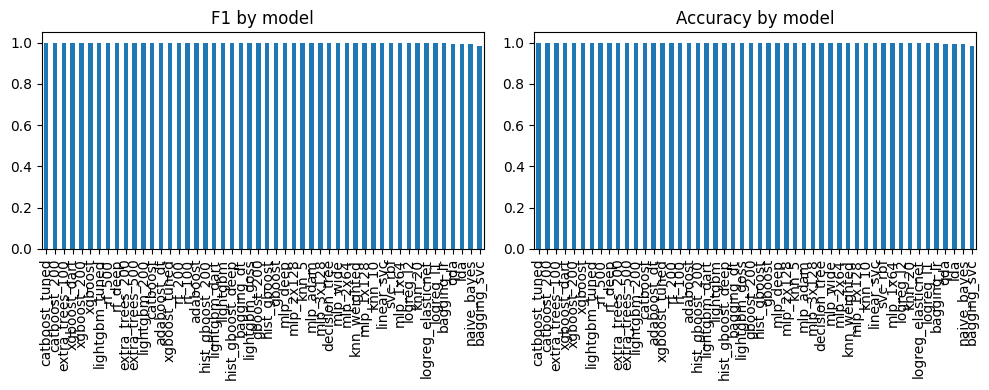

In [3]:
import matplotlib.pyplot as plt
cv_df = pd.DataFrame(cv_results).T.sort_values('f1', ascending=False)
display(cv_df)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cv_df['f1'].plot(kind='bar', ax=axes[0], title='F1 by model')
cv_df['acc'].plot(kind='bar', ax=axes[1], title='Accuracy by model')
plt.tight_layout()
plt.show()


In [4]:
# Fit the best model on full train and evaluate on holdout test
best_name = sorted(cv_results.items(), key=lambda kv: kv[1]["f1"], reverse=True)[0][0]
best_model = models[best_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("Selected model:", best_name)
print(classification_report(y_test, y_pred, target_names=["benign", "malware"]))


Selected model: catboost_tuned
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      5860
     malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

